<a href="https://colab.research.google.com/github/parths7/Attention_Transformer_TimeSeries/blob/main/AI_Task_Tranformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Design a sequence-to-sequence transformer model based on the “Attention is All You Need”
architecture. The model will process an input sequence of 6-dimensional vectors with a length of
100 using an encoder to create context. The decoder will start with a token of dimension 1 and
sequence length 10, then generate the remaining 90 outputs in a sequence-to-sequence manner.
The task will incorporate masking and positional encoding

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import math

# Load Data

In [ ]:
data_path = f"https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTm1.csv"

data = pd.read_csv(data_path)
data.shape

(69680, 8)

In [ ]:
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [ ]:
data.isnull().sum()

,0
date,0
HUFL,0
HULL,0
MUFL,0
MULL,0
LUFL,0
LULL,0
OT,0


In [ ]:
data.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000
mean,7.413993,2.261418,4.322226,0.896509,3.082888,0.857907,13.320642
std,7.082928,2.041293,6.829189,1.807239,1.174063,0.600440,8.564817
min,-23.242001,-5.693000,-26.367001,-6.041000,-1.188000,-1.371000,-4.221000
25%,5.827000,0.804000,3.305000,-0.284000,2.315000,0.670000,6.964000
50%,8.841000,2.210000,6.005000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.655000,1.218000,18.079000
max,24.180000,10.315000,18.087000,7.853000,8.498000,3.046000,46.007000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69680 entries, 0 to 69679
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    69680 non-null  object 
 1   HUFL    69680 non-null  float64
 2   HULL    69680 non-null  float64
 3   MUFL    69680 non-null  float64
 4   MULL    69680 non-null  float64
 5   LUFL    69680 non-null  float64
 6   LULL    69680 non-null  float64
 7   OT      69680 non-null  float64
dtypes: float64(7), object(1)
memory usage: 4.3+ MB


In [ ]:
batch = next(iter(dataloader))

In [ ]:
batch[0].type()

'torch.FloatTensor'

In [ ]:
len(dataloader)

697

In [ ]:
data.columns

Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

# Data Preprocessing

In [ ]:
input_cols = data.columns[1:8]
output_col = ['OT']

inputs = data[input_cols].values
outputs = data[output_col].values

scaler_inputs = MinMaxScaler()
inputs_scaled = scaler_inputs.fit_transform(inputs)

scaler_outputs = MinMaxScaler()
outputs_scaled = scaler_outputs.fit_transform(outputs)

In [ ]:
inputs_scaled_df = pd.DataFrame(inputs_scaled)
inputs_scaled_df.describe()

,0,1,2,3,4,5,6
count,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000
mean,0.646451,0.496903,0.690359,0.499317,0.440934,0.504620,0.349240
std,0.149360,0.127517,0.153624,0.130073,0.121212,0.135938,0.170519
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.612986,0.405860,0.667476,0.414352,0.361656,0.462078,0.222685
50%,0.676543,0.493691,0.728213,0.503815,0.415135,0.531130,0.310922
75%,0.738687,0.585770,0.787376,0.593350,0.500000,0.586144,0.443975
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Creating the batches with window size 100 and stride of 10. The fuction returns batches, each with length 100.


In [ ]:
def create_sequences(data, seq_length, step):
    sequences = []
    for i in range(0, len(data) - seq_length, step):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

# Create sequences of length 100 with a step size of 10 for input and output
seq_length = 100
step = 10
input_sequences = create_sequences(data.drop(['date', 'OT'], axis = 1), seq_length, step)
output_sequences = create_sequences(outputs_scaled, seq_length, step)

In [ ]:
print(input_sequences.shape) #(Batch, Time Sequence, Channels / Features)
print(output_sequences.shape)

(6958, 100, 6)
(6958, 100, 1)


In [ ]:
train_size = int(0.8 * len(input_sequences))
X_train = input_sequences[:train_size]
y_train = output_sequences[:train_size]
X_val = input_sequences[train_size:]
y_val = output_sequences[train_size:]

X_train_tensors = torch.tensor(X_train, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32)
X_val_tensors = torch.tensor(X_val, dtype=torch.float32)
y_val_tensors = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
val_dataset = TensorDataset(X_val_tensors, y_val_tensors)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Inspecting the shape of data Tensors

In [ ]:
train_loader

In [ ]:
len(train_loader)

174

In [ ]:
batch = next(iter(train_loader))
print(batch[0].shape, batch[1].shape)

torch.Size([32, 100, 6]) torch.Size([32, 100, 1])


In [ ]:
X, y = next(iter(train_loader))

In [ ]:
nn.Parameter(torch.zeros(1, seq_length, d_model))

Linear(in_features=512, out_features=6, bias=True)


In [ ]:
tg = torch.cat((tok, y[:, :-10]), dim=1)

In [ ]:
tg

torch.Size([32, 100, 1])

In [ ]:
embd = nn.Linear(6, 512)
s = embd(tg)
s.shape

torch.Size([32, 100, 512])

In [ ]:
st_token = torch.zeros(X.size(0), 10, 1)
print(X.size(), st_token.size())

torch.Size([32, 100, 6]) torch.Size([32, 10, 1])


In [ ]:
tg = torch.cat((st_token, y[:, :-10]), dim=1)
print(tg.size())

torch.Size([32, 100, 1])


In [ ]:
tok.size()

torch.Size([32, 10, 1])

In [ ]:
y[:, :-10].size()

torch.Size([32, 90, 1])

In [ ]:
torch.cat((tok, y[:, :-10]), dim=1).shape

torch.Size([32, 100, 1])

# Model Architcture

In [ ]:
# Add a mask function to generate the look-ahead mask for the decoder
def generate_square_subsequent_mask(sz):
    """
    Generate a square mask for the sequence. The mask will prevent the model from
    attending to future positions in the sequence.
    """
    mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    return mask

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim_src, input_dim_tgt, d_model, num_heads, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_dim_src = input_dim_src
        self.input_dim_tgt = input_dim_tgt
        self.d_model = d_model

        # Embedding layer
        self.src_embedding = nn.Linear(input_dim_src, d_model)
        self.tgt_embedding = nn.Linear(input_dim_tgt, d_model)

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, d_model))

        # Transformer layers
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )

        # Output layer
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src, tgt, tgt_mask=None):
        # Embed the input sequence
        src = self.src_embedding(src) + self.positional_encoding  #src: [32, 100, 6] -> [32, 100, 512] || [batch_size, sequence_length, d_model]
        tgt = self.tgt_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]  #tgt: [32, 10, 1] ->  [32, 10, 512] || [batch_size, sequence_length, d_model]

        # Transformer expects input in shape [sequence_length, batch_size, d_model]
        src = src.permute(1, 0, 2)  # -> [sequence_length, batch_size, d_model]
        tgt = tgt.permute(1, 0, 2)  # -> [sequence_length, batch_size, d_model]

        # Transformer forward pass with masking
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        output = output.permute(1, 0, 2)  # ->  [batch_size, sequence_length, d_model]

        # Final output layer
        output = self.fc_out(output)
        return output


In [ ]:
# Modify the training function to include masking
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device = None):
    #model = model.to(device)
    best_train_loss = float('inf')
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # target defined as shifted sequence (auto-regressive)
            start_token = torch.zeros(X_batch.size(0), 10, 1).to(device)  # Start token with sequence length 10
            tgt = torch.cat((start_token, y_batch[:, :-10]), dim=1)  # Shifted output

            # Generate the mask for the target sequence
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(X_batch, tgt, tgt_mask=tgt_mask)

            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                start_token = torch.zeros(X_batch.size(0), 10, 1).to(device)  # Start token with sequence length 10
                tgt = torch.cat((start_token, y_batch[:, :-10]), dim=1) #Shifted Output

                # Generate the mask for the target sequence
                tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)

                outputs = model(X_batch, tgt, tgt_mask=tgt_mask)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if train_loss < best_train_loss and val_loss < best_val_loss:
            best_train_loss = train_loss
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_transformer_model.pth')
            print("Best model saved!")

# Build Model

In [ ]:
model = TimeSeriesTransformer(
    input_dim_src=6,
    input_dim_tgt=1,
    d_model=512,
    num_heads=4,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=256
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model

In [ ]:
train_model(model, train_loader, val_loader, epochs=20, criterion=criterion, optimizer=optimizer)

Epoch 1, Train Loss: 0.2796, Val Loss: 0.1661
Best model saved!
Epoch 2, Train Loss: 0.1540, Val Loss: 0.1548
Best model saved!
Epoch 3, Train Loss: 0.1474, Val Loss: 0.1545
Best model saved!
Epoch 4, Train Loss: 0.1463, Val Loss: 0.1890
Epoch 5, Train Loss: 0.1451, Val Loss: 0.2037
Epoch 6, Train Loss: 0.1454, Val Loss: 0.1030
Best model saved!
Epoch 7, Train Loss: 0.1433, Val Loss: 0.1237
Epoch 8, Train Loss: 0.1438, Val Loss: 0.1405
Epoch 9, Train Loss: 0.1442, Val Loss: 0.0826
Best model saved!
Epoch 10, Train Loss: 0.1435, Val Loss: 0.1858
Epoch 11, Train Loss: 0.1410, Val Loss: 0.1030
Epoch 12, Train Loss: 0.1408, Val Loss: 0.1826
Epoch 13, Train Loss: 0.1414, Val Loss: 0.1337
Epoch 14, Train Loss: 0.1408, Val Loss: 0.1272
Epoch 15, Train Loss: 0.1412, Val Loss: 0.1379
Epoch 16, Train Loss: 0.1410, Val Loss: 0.1608
Epoch 17, Train Loss: 0.1413, Val Loss: 0.1805
Epoch 18, Train Loss: 0.1411, Val Loss: 0.0908
Epoch 19, Train Loss: 0.1414, Val Loss: 0.2092
Epoch 20, Train Loss: 0.14

In [ ]:
model.load_state_dict(torch.load('best_transformer_model.pth'))

<ipython-input-23-5aa5439e336d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_transformer_model.pth'))


<All keys matched successfully>

# Model Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    predictions, ground_truth = [], []
    for X_batch, y_batch in val_loader:
        #X_batch = X_batch.to(device)
        start_token = torch.zeros(X_batch.size(0), 10, 1)
        tgt = torch.cat((start_token, torch.zeros_like(y_batch[:, :-10])), dim=1)
        outputs = model(X_batch, tgt).cpu().numpy()
        predictions.append(outputs)
        ground_truth.append(y_batch.numpy())

predictions = np.concatenate(predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)

MAE Error is tensor(0.0831)


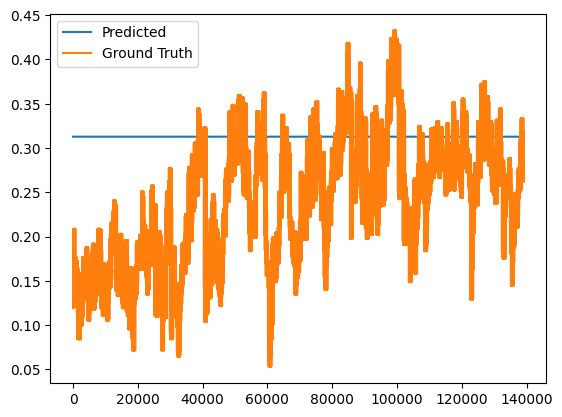

In [ ]:
MAE = nn.L1Loss()
error = MAE(torch.from_numpy(predictions), torch.from_numpy(ground_truth))
print('MAE Error is', error)
plt.plot(predictions.flatten(), label='Predicted')
plt.plot(ground_truth.flatten(), label='Ground Truth')
plt.legend()
plt.show()

# Conclusion
* Eventhough Our model performs well according to the obtained MAE score of 0.0831 by just fitting a regression line parallel to x axis (Y = 0*X + 0.35).

* The model does not give a good fit. The model may fail for a data with a different trend.

**Next Steps of Improvement:**

* Larger data with a more varied trend can benifit the learning.

* Leverage dates / time for positional encoding, Use the training feature as embedding vector for OT.

* Use Informer model based on transformer's encode-decoder architecture for regression based tasks

